In [1]:
# Verify the GPU is visible to the container
!nvidia-smi

Tue Jun 10 19:46:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77.01              Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti     On  |   00000000:09:00.0  On |                  N/A |
|  0%   52C    P8             13W /  290W |    1035MiB /   8192MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# The core libraries are pre-installed. We only install small helper packages.
# NOTE: Do NOT reinstall torch, torchvision, or torch_tensorrt!
!pip install ipywidgets matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
# --- Python Imports ---
import torch
import torchvision
import torch_tensorrt
import numpy as np
import json
import time
import os
import random
from pathlib import Path

# --- Helper Imports ---
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.export

# --- Environment Setup for Performance ---
torch.cuda.is_available()
torch.backends.cudnn.benchmark = True

print(f"PyTorch Version: {torch.__version__}")
print(f"Torch-TensorRT Version: {torch_tensorrt.__version__}")
print(f"Is CUDA available? {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.3.0a0+6ddf5cf85e.nv24.04
Torch-TensorRT Version: 2.3.0a0
Is CUDA available? True
CUDA device: NVIDIA GeForce RTX 3070 Ti


In [4]:
# ==============================================================================
# ## ⚠️ USER CONFIGURATION ##
# Define paths as they exist INSIDE the container.
# Your local 'C:\Uni\deep_model_optimization' is mapped to '/workspace'.
# ==============================================================================
BASE_DIR = Path('/workspace')

# Path to your fine-tuned model file
MODEL_PATH = BASE_DIR / 'saved_models_and_logs' / 'resnet50_baseline' / 'resnet50_baseline_ft_imagenetmini_final.pth'

# Path to your dataset
DATA_DIR = BASE_DIR / 'imagenet-mini'

# Path to save the optimized models to. This will appear in your local project folder.
OPTIMIZED_MODEL_DIR = BASE_DIR / 'optimized_models'
# ==============================================================================

# Create the output directory if it doesn't exist
OPTIMIZED_MODEL_DIR.mkdir(exist_ok=True)

print(f"✅ Base Directory inside container: {BASE_DIR}")
print(f"✅ Model will be loaded from: {MODEL_PATH}")
print(f"✅ Optimized models will be saved to: {OPTIMIZED_MODEL_DIR}")

# Verify that the model file actually exists at that path
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model file not found inside container at: {MODEL_PATH}")

✅ Base Directory inside container: /workspace
✅ Model will be loaded from: /workspace/saved_models_and_logs/resnet50_baseline/resnet50_baseline_ft_imagenetmini_final.pth
✅ Optimized models will be saved to: /workspace/optimized_models


In [5]:
# --- Load the Fine-Tuned Model ---

# 1. Instantiate the model architecture.
# Ensure num_classes matches the output of your fine-tuned model.
model = models.resnet50(num_classes=1000)

# 2. Load the state dictionary from your .pth file.
# Using map_location='cpu' is a safe practice.
state_dict = torch.load(MODEL_PATH, map_location='cpu')

# 3. Load the weights into the model.
# This handles cases where the weights are saved inside a dictionary.
if 'model_state_dict' in state_dict:
    model.load_state_dict(state_dict['model_state_dict'])
elif 'state_dict' in state_dict:
    model.load_state_dict(state_dict['state_dict'])
else:
    model.load_state_dict(state_dict)

# 4. Set the model to evaluation mode. This is crucial for inference.
model.eval()

# 5. Move the model to the GPU.
model = model.to("cuda")

print("Custom fine-tuned ResNet-50 model loaded and moved to GPU successfully.")

Custom fine-tuned ResNet-50 model loaded and moved to GPU successfully.


In [6]:
# --- Utility Functions ---

def rn50_preprocess():
    """Standard ResNet50 preprocessing."""
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

def predict(img_path, model_to_test, class_mapping):
    """Run inference on a single image."""
    img = Image.open(img_path).convert('RGB')
    preprocess = rn50_preprocess()
    input_tensor = preprocess(img).unsqueeze(0).to("cuda") # create a mini-batch and move to GPU

    with torch.no_grad():
        output = model_to_test(input_tensor)
        sm_output = torch.nn.functional.softmax(output[0], dim=0)

    ind = torch.argmax(sm_output)
    return class_mapping[str(ind.item())], sm_output[ind].item()

def benchmark(model_to_benchmark, input_shape=(128, 3, 224, 224), dtype='fp32', nwarmup=50, nruns=100):
    """Benchmark the model with random data. Handles both nn.Module and ExportedProgram."""
    input_data = torch.randn(input_shape).to("cuda")
    if dtype == 'fp16':
        input_data = input_data.half()

    # --- KEY CHANGE IS HERE ---
    # Check if the model has an 'eval' method before calling it.
    # This makes the function compatible with both standard PyTorch models
    # and the newer ExportedProgram objects from torch.export.
    if hasattr(model_to_benchmark, 'eval'):
        model_to_benchmark.eval()
    # --------------------------

    print(f"--- Benchmarking ({dtype}) ---")
    print(f"Warm up for {nwarmup} runs...")
    with torch.no_grad():
        for _ in range(nwarmup):
            # For ExportedProgram, the input must be a tuple of args
            _ = model_to_benchmark(input_data)
    torch.cuda.synchronize()

    print(f"Starting timing for {nruns} runs...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns + 1):
            start_time = time.time()
            # For ExportedProgram, the input must be a tuple of args
            _ = model_to_benchmark(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i % (nruns // 10) == 0:
                print(f'Iteration {i}/{nruns}, avg batch time: {np.mean(timings) * 1000:.2f} ms')

    avg_time_ms = np.mean(timings) * 1000
    print("\n--- Results ---")
    print(f'Average batch time: {avg_time_ms:.2f} ms')
    return avg_time_ms

ILSVRC2012_val_00044873.JPEG - Predicted: hatchet, Probability: 0.6355
ILSVRC2012_val_00015807.JPEG - Predicted: Maltese_dog, Probability: 0.9737
ILSVRC2012_val_00020286.JPEG - Predicted: fly, Probability: 0.9407
ILSVRC2012_val_00021403.JPEG - Predicted: tobacco_shop, Probability: 0.2905


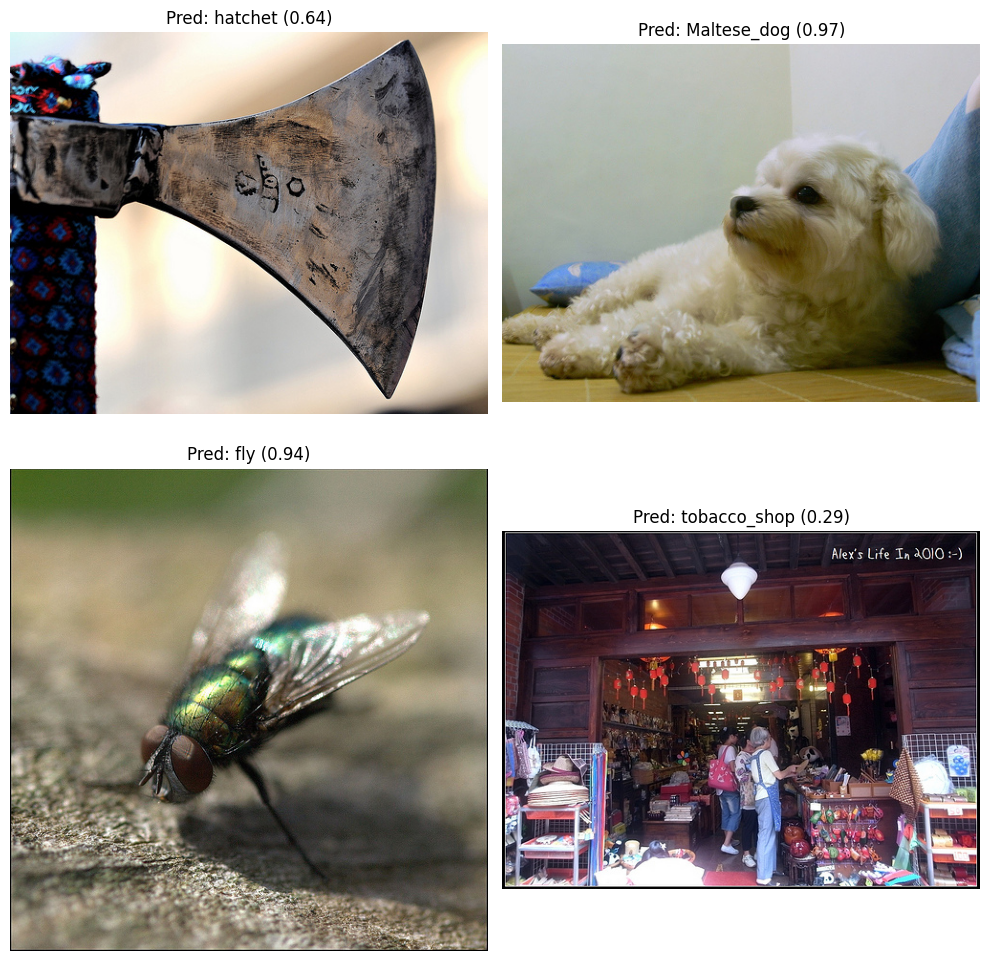

In [7]:
# --- Load Class Mappings and Find Sample Images ---
IMAGENET_CLASS_INDEX_URL = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
CLASS_INDEX_PATH = BASE_DIR / 'imagenet_class_index.json'

# Download the class index file if it doesn't exist
if not CLASS_INDEX_PATH.exists():
    print("Downloading ImageNet class index...")
    import requests
    response = requests.get(IMAGENET_CLASS_INDEX_URL)
    with open(CLASS_INDEX_PATH, 'w') as f:
        f.write(response.text)

# Load the class index
with open(CLASS_INDEX_PATH) as json_file:
    class_idx = json.load(json_file)

# Find some random sample images from your validation set
val_dir = DATA_DIR / 'val'
sample_image_paths = []
if val_dir.exists():
    class_folders = [d for d in val_dir.iterdir() if d.is_dir()]
    if class_folders:
        for _ in range(4):
            random_class_folder = random.choice(class_folders)
            random_image = random.choice(list(random_class_folder.glob('*.JPEG')))
            sample_image_paths.append(random_image)

# Verify predictions on sample images
if sample_image_paths:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    for i, img_path in enumerate(sample_image_paths):
        img = Image.open(img_path).convert('RGB')
        pred, prob = predict(img_path, model, class_idx)
        print(f'{img_path.name} - Predicted: {pred[1]}, Probability: {prob:.4f}')

        ax = plt.subplot(2, 2, i + 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Pred: {pred[1]} ({prob:.2f})")
    plt.tight_layout()
    plt.show()
else:
    print(f"Could not find sample images in {val_dir}. Skipping prediction test.")

In [8]:
# --- Run Baseline Benchmark ---
print("Benchmarking original, un-optimized PyTorch model...")
baseline_time = benchmark(model, input_shape=(128, 3, 224, 224), nruns=100)

Benchmarking original, un-optimized PyTorch model...
--- Benchmarking (fp32) ---
Warm up for 50 runs...
Starting timing for 100 runs...
Iteration 10/100, avg batch time: 136.40 ms
Iteration 20/100, avg batch time: 136.39 ms
Iteration 30/100, avg batch time: 136.67 ms
Iteration 40/100, avg batch time: 136.55 ms
Iteration 50/100, avg batch time: 136.58 ms
Iteration 60/100, avg batch time: 136.71 ms
Iteration 70/100, avg batch time: 136.76 ms
Iteration 80/100, avg batch time: 136.75 ms
Iteration 90/100, avg batch time: 136.80 ms
Iteration 100/100, avg batch time: 136.86 ms

--- Results ---
Average batch time: 136.86 ms


In [10]:
# --- Compile and Save for FP32 (with proper saving method) ---
print("Compiling model with Torch-TensorRT (FP32)...")
print("Using smaller batch size (32) for compilation to conserve memory.")

# Method 1: Use TorchScript IR explicitly
trt_model_fp32 = torch_tensorrt.compile(
    model,
    inputs=[torch_tensorrt.Input((32, 3, 224, 224), dtype=torch.float32)],
    enabled_precisions={torch.float32},
    workspace_size=1 << 26,  # 64MB
    ir="torchscript"  # Explicitly use TorchScript IR
)
print("Compilation complete.")

# Save the FP32 optimized model (this will work with TorchScript IR)
fp32_model_path = OPTIMIZED_MODEL_DIR / 'resnet50_trt_fp32.ts'
torch.jit.save(trt_model_fp32, fp32_model_path)
print(f"FP32 optimized model saved to: {fp32_model_path}")

INFO:torch_tensorrt._compile:Module was provided as a torch.nn.Module, trying to script the module with torch.jit.script. In the event of a failure please preconvert your module to TorchScript


Compiling model with Torch-TensorRT (FP32)...
Using smaller batch size (32) for compilation to conserve memory.


Compilation complete.
FP32 optimized model saved to: /workspace/optimized_models/resnet50_trt_fp32.ts


In [11]:
# --- Compile and Save for FP16 ---
print("Compiling model with Torch-TensorRT (FP16)...")
print("Using smaller batch size (32) for compilation to conserve memory.")

# IMPORTANT: We use a smaller batch size here ONLY for the compilation step
# to avoid potential out-of-memory errors on consumer GPUs.
trt_model_fp16 = torch_tensorrt.compile(
    model,
    inputs=[torch_tensorrt.Input((32, 3, 224, 224), dtype=torch.float16)], # Input dtype is now float16
    enabled_precisions={torch.float16},                                   # Target precision is now float16
    workspace_size=1 << 26, # 64MB workspace is usually sufficient
    ir="torchscript"  # Explicitly use TorchScript IR
)

print("Compilation complete.")

# Save the FP16 optimized model
fp16_model_path = OPTIMIZED_MODEL_DIR / 'resnet50_trt_fp16.ts'
torch.jit.save(trt_model_fp16, fp16_model_path)
print(f"FP16 optimized model saved to: {fp16_model_path}")

INFO:torch_tensorrt._compile:Module was provided as a torch.nn.Module, trying to script the module with torch.jit.script. In the event of a failure please preconvert your module to TorchScript


Compiling model with Torch-TensorRT (FP16)...
Using smaller batch size (32) for compilation to conserve memory.


The compiler is going to use the user setting Half
This conflict may cause an error at runtime due to partial compilation being enabled and therefore
compatibility with PyTorch's data type convention is required.
If you do indeed see errors at runtime either:
- Remove the dtype spec for x.1
- Disable partial compilation by setting require_full_compilation to True


Compilation complete.
FP16 optimized model saved to: /workspace/optimized_models/resnet50_trt_fp16.ts
